
# Capstone EDA → Modeling Readiness (A–G)
This notebook performs **focused EDA** and **model‑readiness** steps to support the following capabilities:

**A. Risk Tolerance Prediction (Classification)**  
**B. Customer Segmentation (Clustering with KMeans)**  
**C. Investment Product Recommendation (Multi‑class Classification)**  
**D. Anomaly Detection (Isolation Forest)**  
**E. Fairness & Bias Analysis (Race / Gender / City Tier)**  
**F. Sentiment & Satisfaction Analysis (Comment → sentiment; link to satisfaction & risk)**

For the Capstone i am using the data from financial data from
https://www.kaggle.com/code/emremsr/finance-data/input

and enriched the data with additional columns
Education Level	Annual Income	Employment Status	Risk Tolerance	Race	City Tier	Which investment avenue do you mostly invest in?	Comment


 


In [24]:

import os, re, math, itertools, json, textwrap, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.utils.multiclass import type_of_target

np.random.seed(42)

# === Load ===
DATA_PATH = "Combined_Investment_Data_100k_full.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Original shape:", df.shape)

Original shape: (100000, 27)


In [ ]:



rename_map = {
    "What do you think are the best options for investing your money? (Rank in order of preference) [Mutual Funds]": "best_option_mutual_funds",
    "What do you think are the best options for investing your money? (Rank in order of preference) [Equity Market]": "best_option_equity_market",
    "What do you think are the best options for investing your money? (Rank in order of preference) [Debentures]": "best_option_debentures",
    "What do you think are the best options for investing your money? (Rank in order of preference) [Government Bonds]": "best_option_government_bonds",
    "What do you think are the best options for investing your money? (Rank in order of preference) [Fixed Deposits]": "best_option_fixed_deposits",
    "What do you think are the best options for investing your money? (Rank in order of preference) [Public Provident Fund]": "best_option_ppf",
    "What do you think are the best options for investing your money? (Rank in order of preference) [Gold]": "best_option_gold",
    "How long do you prefer to keep your money in any investment instrument?": "holding_period",
    "How much return do you expect from any investment instrument?": "return_expectation"
}

df.rename(columns=rename_map, inplace=True)
# renamed columns
df.head()
df.info()
display(df.describe(include='all').transpose())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   GENDER                                            98095 non-null  object 
 1   AGE                                               99010 non-null  float64
 2   Do you invest in Investment Avenues?              96958 non-null  object 
 3   best_option_mutual_funds                          98009 non-null  float64
 4   best_option_equity_market                         98027 non-null  float64
 5   best_option_debentures                            98034 non-null  float64
 6   best_option_government_bonds                      97950 non-null  float64
 7   best_option_fixed_deposits                        97949 non-null  float64
 8   best_option_ppf                                   97975 non-null  float64
 9   best_option_gold

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
GENDER,98095,3,Male,53958,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,99010.0,NaN,NaN,NaN,41.488244,13.845626,18.0,30.0,41.0,54.0,65.0
Do you invest in Investment Avenues?,96958,2,Yes,77483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
best_option_mutual_funds,98009.0,NaN,NaN,NaN,3.999561,2.004502,1.0,2.0,4.0,6.0,7.0
best_option_equity_market,98027.0,NaN,NaN,NaN,4.000133,1.996015,1.0,2.0,4.0,6.0,7.0
best_option_debentures,98034.0,NaN,NaN,NaN,4.00252,2.001286,1.0,2.0,4.0,6.0,7.0
best_option_government_bonds,97950.0,NaN,NaN,NaN,3.998693,2.001168,1.0,2.0,4.0,6.0,7.0
best_option_fixed_deposits,97949.0,NaN,NaN,NaN,4.005687,1.994837,1.0,2.0,4.0,6.0,7.0
best_option_ppf,97975.0,NaN,NaN,NaN,3.987201,2.005153,1.0,2.0,4.0,6.0,7.0
best_option_gold,97951.0,NaN,NaN,NaN,4.00292,1.997061,1.0,2.0,4.0,6.0,7.0


In [27]:
missing_counts = df.isna().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({'missing_count': missing_counts, 'missing_pct': missing_pct})                         .sort_values('missing_pct', ascending=False)
display(missing_df.head(20))

dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

,missing_count,missing_pct
Annual Income,4995,4.995
Risk Tolerance,4955,4.955
Education Level,4908,4.908
Employment Status,4896,4.896
Which investment avenue do you mostly invest in?,4050,4.050
holding_period,4028,4.028
What are your savings objectives?,3988,3.988
return_expectation,3061,3.061
Race,3045,3.045
Do you invest in Investment Avenues?,3042,3.042


Duplicate rows: 0


In [28]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]
print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

cardinality = df.nunique().sort_values(ascending=False)
cardinality.head(20)

Numeric columns: 9
Categorical columns: 18


Annual Income                                       94093
AGE                                                    48
Comment                                                29
best_option_fixed_deposits                              7
best_option_ppf                                         7
best_option_debentures                                  7
best_option_government_bonds                            7
best_option_gold                                        7
Which investment avenue do you mostly invest in?        7
best_option_equity_market                               7
best_option_mutual_funds                                7
Education Level                                         5
Race                                                    5
Employment Status                                       5
How often do you monitor your investment?               5
Your sources of information for investments is          4
What are your savings objectives?                       4
holding_period

In [29]:

# === Normalize column names ===
def normalize_col(c):
    c = str(c).strip()
    c = re.sub(r'[%]','pct',c)
    c = re.sub(r'[^0-9a-zA-Z_ ]','', c)
    c = re.sub(r'\s+',' ', c).strip().lower().replace(' ', '_')
    return c

df.columns = [normalize_col(c) for c in df.columns]

# Try to coerce numeric-looking strings
for col in df.columns:
    if df[col].dtype == object:
        coerced = pd.to_numeric(df[col].astype(str).str.replace(',','', regex=True), errors='coerce')
        if coerced.notna().mean() > 0.8:
            df[col] = coerced

# Identify likely text/comment field
text_cols_guess = [c for c in df.columns if any(k in c for k in ["comment","notes","free_text","review"])]
print("Detected text/comment columns:", text_cols_guess)

# Basic type splits
num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if (df[c].dtype == object)]
print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

# Missing values imputation (keep copy of original for reference)
df_clean = df.copy()

for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())
for c in cat_cols:
    df_clean[c] = df_clean[c].fillna("Unknown")

# Outlier capping via IQR
def cap_outliers(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or not np.isfinite(iqr):
        return s
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return s.clip(lower, upper)

for c in num_cols:
    df_clean[c] = cap_outliers(df_clean[c])

print("Cleaned shape:", df_clean.shape)


Detected text/comment columns: ['comment']
Numeric cols: 9 | Categorical cols: 18
Cleaned shape: (100000, 27)


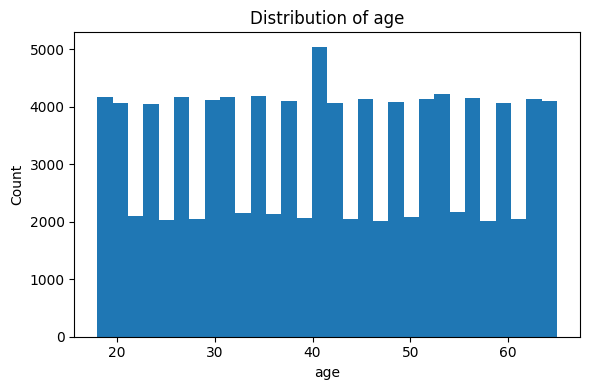

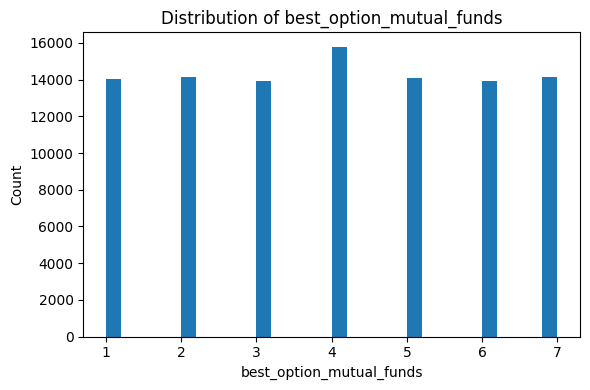

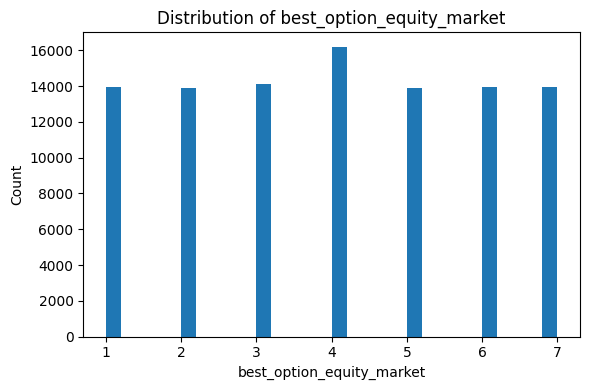

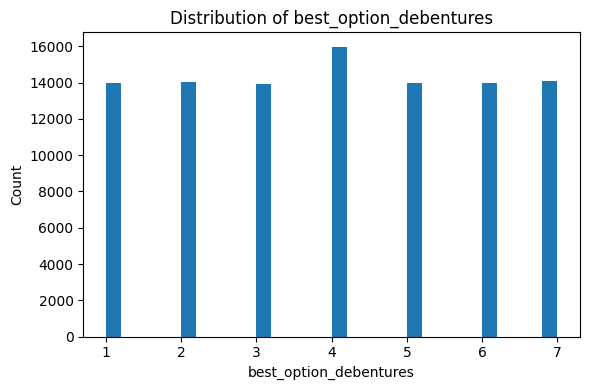

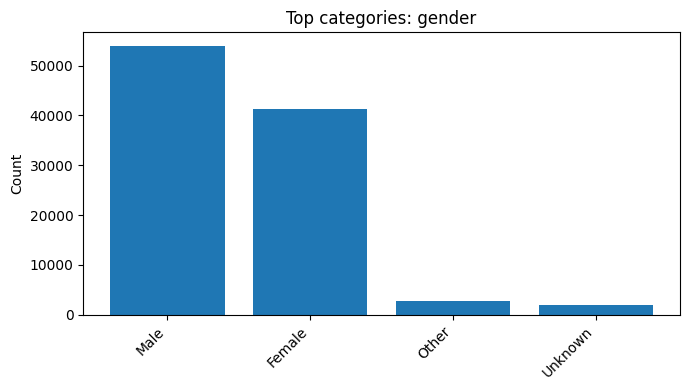

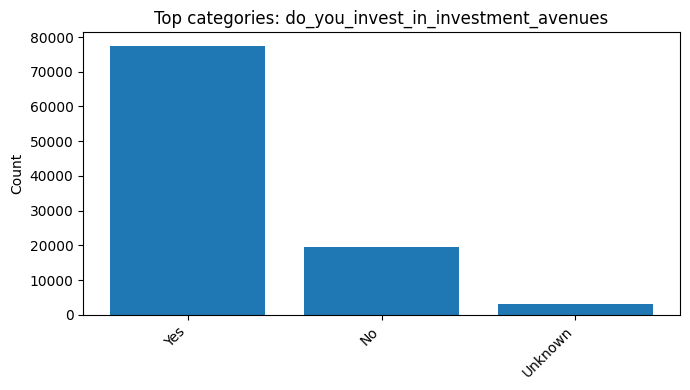

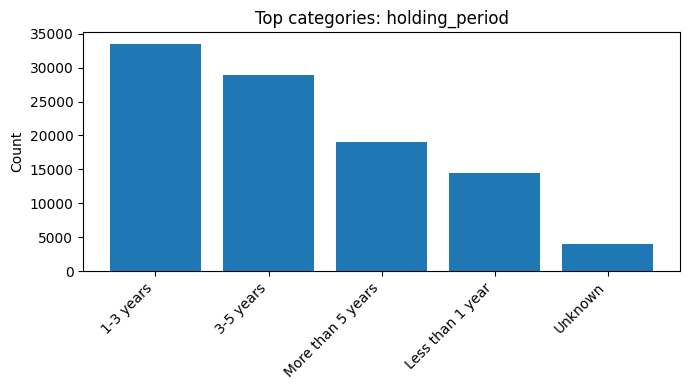

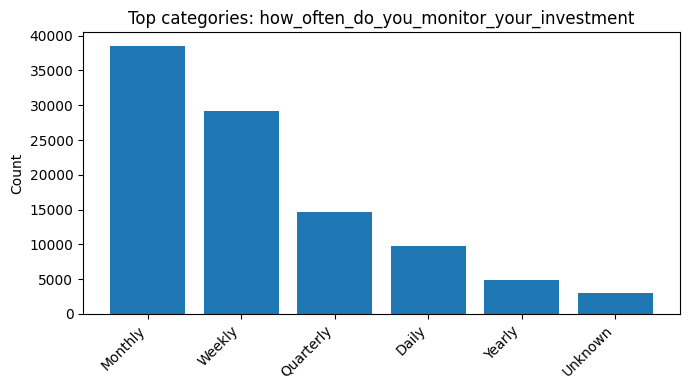

In [30]:

# Quick sanity plots (optional): first 4 numeric histograms and first 4 categorical bars
plot_num = num_cols[:4]
for c in plot_num:
    if c in df_clean:
        plt.figure(figsize=(6,4))
        plt.hist(df_clean[c].dropna().values, bins=30)
        plt.title(f"Distribution of {c}")
        plt.xlabel(c); plt.ylabel("Count")
        plt.tight_layout(); plt.show()

plot_cat = cat_cols[:4]
for c in plot_cat:
    if c in df_clean:
        vc = df_clean[c].astype(str).value_counts().head(10)
        plt.figure(figsize=(7,4))
        plt.bar(vc.index.tolist(), vc.values.tolist())
        plt.title(f"Top categories: {c}")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Count")
        plt.tight_layout(); plt.show()


In [31]:

def find_first(patterns):
    for p in patterns:
        for c in df_clean.columns:
            if p in c:
                return c
    return None

col_risk   = find_first(["risk_tolerance","risklevel","risk"])
col_avenue = find_first(["which_investment_avenue","mostly_invest","investment_avenue","which_investment"])
col_gender = find_first(["gender","sex"])
col_race   = find_first(["race","ethnicity"])
col_city   = find_first(["city_tier","tier"])
col_comment= text_cols_guess[0] if text_cols_guess else None
col_satisf = find_first(["satisfaction"])

print("Targets detected:")
print(" - Risk tolerance:", col_risk)
print(" - Investment avenue:", col_avenue)
print("Sensitive attrs: gender:", col_gender, "| race:", col_race, "| city tier:", col_city)
print("Comment field:", col_comment, "| Satisfaction:", col_satisf)


Targets detected:
 - Risk tolerance: risk_tolerance
 - Investment avenue: which_investment_avenue_do_you_mostly_invest_in
Sensitive attrs: gender: gender | race: race | city tier: city_tier
Comment field: comment | Satisfaction: None


In [32]:

# === G. Sentiment Analysis (basic) ===

def simple_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    text_l = text.lower()
    pos = ["good","great","excellent","happy","satisfied","love","positive","benefit","gain","profit"]
    neg = ["bad","poor","terrible","sad","angry","unsatisfied","hate","negative","loss","risk"]
    score = sum(1 for w in pos if w in text_l) - sum(1 for w in neg if w in text_l)
    return float(score)

if col_comment:
    df_clean["sentiment_score"] = df_clean[col_comment].astype(str).map(simple_sentiment)
    print("Sample sentiment scores:", df_clean["sentiment_score"].head().tolist())
else:
    print("No comment/text column found; skipping sentiment score creation.")


Sample sentiment scores: [0.0, -1.0, 0.0, -1.0, 0.0]


Risk Tolerance → Accuracy: 0.8839 | Macro-F1: 0.6597

Classification report:
               precision    recall  f1-score   support

        High       0.82      0.74      0.78      3789
         Low       0.80      0.96      0.87      6626
      Medium       0.99      0.99      0.99      8594
     Unknown       0.00      0.00      0.00       991

    accuracy                           0.88     20000
   macro avg       0.65      0.67      0.66     20000
weighted avg       0.84      0.88      0.86     20000



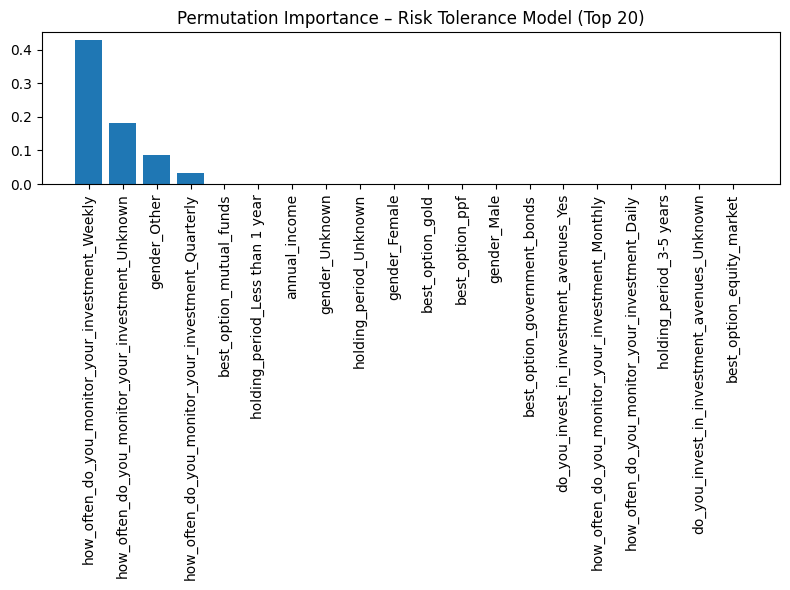

In [33]:

# === A. Risk Tolerance Prediction (Classification) ===
results_A = {}
if col_risk:
    # Build X/y
    y = df_clean[col_risk].astype(str)
    X = df_clean.drop(columns=[col_risk])

    # Split columns by type again post-clean
    X_num = [c for c in X.columns if is_numeric_dtype(X[c])]
    X_cat = [c for c in X.columns if X[c].dtype == object]

    pre = ColumnTransformer(transformers=[
        ("num", SimpleImputer(strategy="median"), X_num),
        ("cat", Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                               ("oh", OneHotEncoder(handle_unknown="ignore"))]), X_cat)
    ])

    # Use a compact yet strong baseline
    clf = Pipeline(steps=[("pre", pre),
                          ("model", GradientBoostingClassifier(random_state=42))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    f1m  = f1_score(y_test, preds, average="macro")
    print("Risk Tolerance → Accuracy:", round(acc,4), "| Macro-F1:", round(f1m,4))
    print("\nClassification report:\n", classification_report(y_test, preds))

    # Permutation importance for explainability
    try:
        perm = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=1)
        importances = perm.importances_mean
        # Retrieve feature names from ColumnTransformer
        oh = clf.named_steps["pre"].named_transformers_["cat"].named_steps["oh"]
        cat_features = oh.get_feature_names_out(X_cat).tolist() if len(X_cat) else []
        feature_names = X_num + cat_features
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(8,6))
        plt.bar(range(len(idx)), importances[idx])
        plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=90)
        plt.title("Permutation Importance – Risk Tolerance Model (Top 20)")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Permutation importance unavailable:", e)

    results_A = {"accuracy": acc, "macro_f1": f1m}
else:
    print("No risk tolerance column detected; skipping A.")


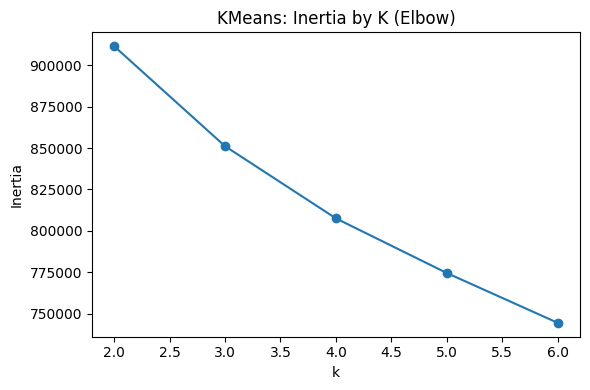

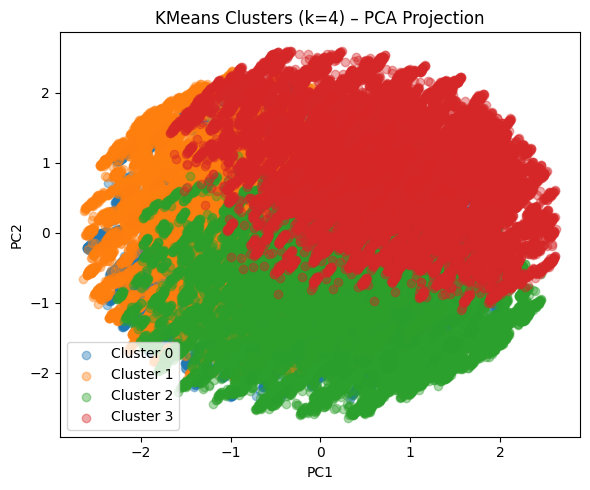

In [34]:

# === B. Customer Segmentation (KMeans) ===
results_B = {}
# Use numeric features only; add engineered sentiment if exists
cluster_df = df_clean[[c for c in df_clean.columns if is_numeric_dtype(df_clean[c])]].copy()
cluster_df = cluster_df.replace([np.inf, -np.inf], np.nan).fillna(0)

if cluster_df.shape[1] >= 2 and cluster_df.shape[0] >= 50:
    scaler = StandardScaler()
    Xc = scaler.fit_transform(cluster_df)

    # Elbow-like quick sweep of inertia for k=2..6
    inertias = []
    K = list(range(2,7))
    for k in K:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(Xc)
        inertias.append(km.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(K, inertias, marker='o')
    plt.title("KMeans: Inertia by K (Elbow)")
    plt.xlabel("k"); plt.ylabel("Inertia")
    plt.tight_layout(); plt.show()

    # Choose k=4 by default
    k = 4
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xc)
    results_B["k"] = k
    df_clean["cluster_k4"] = labels

    # PCA 2D scatter
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(Xc)
    plt.figure(figsize=(6,5))
    for lab in sorted(set(labels)):
        pts = X2[labels==lab]
        plt.scatter(pts[:,0], pts[:,1], alpha=0.4, label=f"Cluster {lab}")
    plt.title("KMeans Clusters (k=4) – PCA Projection")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout(); plt.show()

else:
    print("Insufficient numeric features/rows for clustering; skipping B.")


Investment Avenue → Accuracy: 0.3346 | Macro-F1: 0.1083

Classification report:
                        precision    recall  f1-score   support

           Debentures       0.00      0.00      0.00      1211
        Equity Market       0.40      0.39      0.39      3841
       Fixed Deposits       0.28      0.00      0.00      2738
                 Gold       0.00      0.00      0.00      1650
     Government Bonds       0.29      0.00      0.00      2054
         Mutual Funds       0.32      0.84      0.46      6162
Public Provident Fund       0.20      0.00      0.00      1534
              Unknown       0.00      0.00      0.00       810

             accuracy                           0.33     20000
            macro avg       0.19      0.15      0.11     20000
         weighted avg       0.26      0.33      0.22     20000



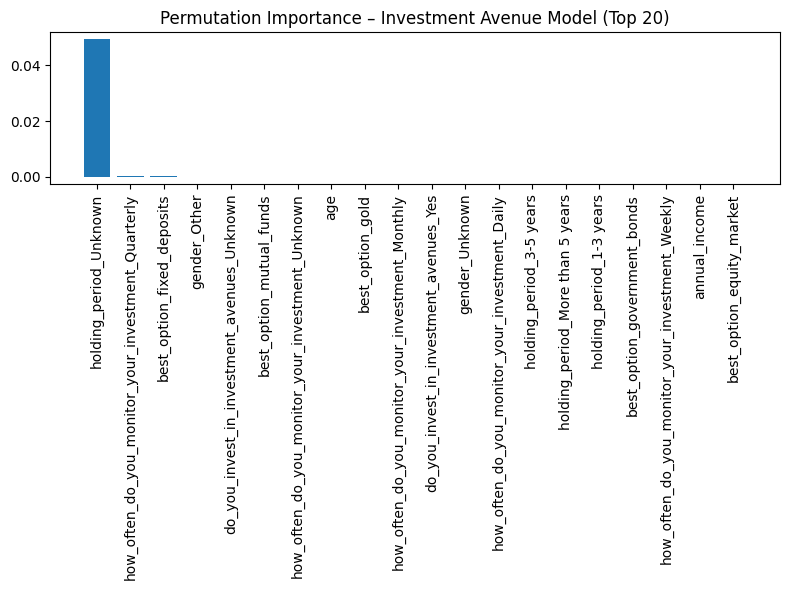

In [35]:

# === C. Investment Product Recommendation (Classification) ===
results_C = {}
if col_avenue:
    y = df_clean[col_avenue].astype(str)
    X = df_clean.drop(columns=[col_avenue])

    X_num = [c for c in X.columns if is_numeric_dtype(X[c])]
    X_cat = [c for c in X.columns if X[c].dtype == object]

    pre = ColumnTransformer(transformers=[
        ("num", SimpleImputer(strategy="median"), X_num),
        ("cat", Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                               ("oh", OneHotEncoder(handle_unknown="ignore"))]), X_cat)
    ])

    clf = Pipeline(steps=[("pre", pre),
                          ("model", GradientBoostingClassifier(random_state=42))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    f1m  = f1_score(y_test, preds, average="macro")
    print("Investment Avenue → Accuracy:", round(acc,4), "| Macro-F1:", round(f1m,4))
    print("\nClassification report:\n", classification_report(y_test, preds))

    # Permutation importance
    try:
        perm = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=1)
        importances = perm.importances_mean
        oh = clf.named_steps["pre"].named_transformers_["cat"].named_steps["oh"]
        cat_features = oh.get_feature_names_out(X_cat).tolist() if len(X_cat) else []
        feature_names = X_num + cat_features
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(8,6))
        plt.bar(range(len(idx)), importances[idx])
        plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=90)
        plt.title("Permutation Importance – Investment Avenue Model (Top 20)")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Permutation importance unavailable:", e)

    results_C = {"accuracy": acc, "macro_f1": f1m}
else:
    print("No investment avenue column detected; skipping C.")


In [36]:

# === D. Anomaly Detection (IsolationForest) ===
anom_df = df_clean[[c for c in df_clean.columns if is_numeric_dtype(df_clean[c])]].copy()
anom_df = anom_df.replace([np.inf, -np.inf], np.nan).fillna(0)

if anom_df.shape[1] >= 2:
    iso = IsolationForest(contamination=0.02, random_state=42)
    scores = iso.fit_predict(anom_df)
    df_clean["anomaly_flag"] = (scores == -1).astype(int)
    print("Anomalies flagged:", int(df_clean["anomaly_flag"].sum()))
    # Show a small sample
    display_cols = (["anomaly_flag"] + anom_df.columns.tolist()[:5])[:6]
    print(df_clean[display_cols].head(10))
else:
    print("Insufficient numeric features for IsolationForest; skipping E.")


Anomalies flagged: 2000
   anomaly_flag   age  best_option_mutual_funds  best_option_equity_market  \
0             0  51.0                       1.0                        3.0   
1             0  25.0                       4.0                        7.0   
2             0  32.0                       7.0                        4.0   
3             0  34.0                       6.0                        7.0   
4             0  23.0                       2.0                        3.0   
5             0  39.0                       7.0                        1.0   
6             0  40.0                       5.0                        2.0   
7             0  55.0                       2.0                        5.0   
8             0  63.0                       1.0                        7.0   
9             0  23.0                       6.0                        7.0   

   best_option_debentures  best_option_government_bonds  
0                     7.0                           4.0  
1

In [37]:

# === E. Fairness & Bias Analysis ===
def group_metrics(y_true, y_pred, group):
    # group: pandas Series of group labels aligned with y_true/y_pred
    dfm = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "grp": group})
    mets = {}
    # Accuracy by group
    for g, sub in dfm.groupby("grp"):
        mets[g] = {
            "count": len(sub),
            "accuracy": accuracy_score(sub["y_true"], sub["y_pred"]),
            "positive_rate_pred": (sub["y_pred"].value_counts(normalize=True).max() 
                                   if len(sub)>0 else np.nan)
        }
    return pd.DataFrame(mets).T

def fairness_report(y_true, y_pred, sensitive_series, title):
    if sensitive_series is None:
        print(f"{title}: Sensitive attribute not found; skipping.")
        return
    print(f"\nFairness report – {title} by {sensitive_series.name}:")
    rep = group_metrics(y_true, y_pred, sensitive_series.astype(str))
    print(rep)
    # Simple parity diffs
    if rep.shape[0] >= 2:
        acc_range = rep["accuracy"].max() - rep["accuracy"].min()
        pos_range = rep["positive_rate_pred"].max() - rep["positive_rate_pred"].min()
        print(f"Accuracy disparity range: {acc_range:.3f} | Pred positive rate disparity range: {pos_range:.3f}")

# Apply to A and C if available
try:
    # For A
    if 'preds' in globals() and col_risk:
        fairness_report(y_test, preds, df_clean.loc[y_test.index, col_gender] if col_gender else None, "Risk Tolerance (Gender)")
        fairness_report(y_test, preds, df_clean.loc[y_test.index, col_race] if col_race else None, "Risk Tolerance (Race)")
        fairness_report(y_test, preds, df_clean.loc[y_test.index, col_city] if col_city else None, "Risk Tolerance (City Tier)")
except Exception as e:
    print("Fairness check (A) skipped/failed:", e)

try:
    # For C: recompute y_test_C, preds_C if not in scope
    pass
except Exception as e:
    print("Fairness check (C) skipped/failed:", e)



Fairness report – Risk Tolerance (Gender) by gender:
           count  accuracy  positive_rate_pred
Female    8324.0  0.333734            0.801898
Male     10760.0  0.335409            0.816171
Other      556.0  0.323741            0.796763
Unknown    360.0  0.347222            0.811111
Accuracy disparity range: 0.023 | Pred positive rate disparity range: 0.019

Fairness report – Risk Tolerance (Race) by race:
                             count  accuracy  positive_rate_pred
Asian                       2970.0  0.334680            0.809764
Black or African American   2278.0  0.325724            0.802458
Hispanic or Latino          2832.0  0.326977            0.818503
Other                        632.0  0.360759            0.818038
Unknown                      585.0  0.328205            0.786325
White                      10703.0  0.337289            0.809493
Accuracy disparity range: 0.035 | Pred positive rate disparity range: 0.032

Fairness report – Risk Tolerance (City Tier) by city_

Sentiment or satisfaction not available; skipping plot.


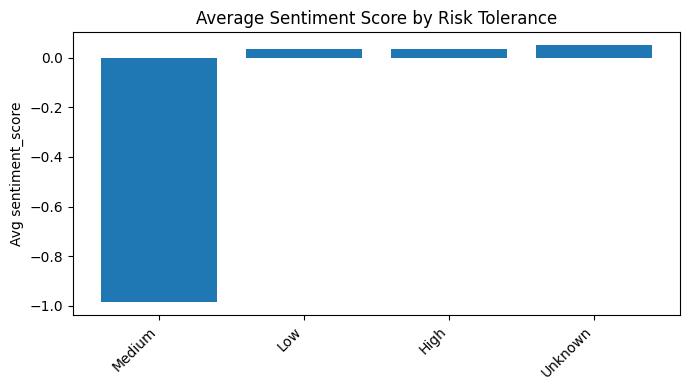

In [38]:

# === F. Sentiment/Satisfaction Link ===
if "sentiment_score" in df_clean.columns and col_satisf:
    # Plot satisfaction vs sentiment
    groups = df_clean[col_satisf].astype(str).value_counts().index[:8]
    means = []
    for g in groups:
        means.append(df_clean.loc[df_clean[col_satisf].astype(str)==g, "sentiment_score"].mean())
    plt.figure(figsize=(7,4))
    plt.bar(list(groups), means)
    plt.title("Average Sentiment Score by Satisfaction")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Avg sentiment_score")
    plt.tight_layout(); plt.show()
else:
    print("Sentiment or satisfaction not available; skipping plot.")

# Link sentiment to risk if available
if "sentiment_score" in df_clean.columns and col_risk:
    groups = df_clean[col_risk].astype(str).value_counts().index[:8]
    means = []
    for g in groups:
        means.append(df_clean.loc[df_clean[col_risk].astype(str)==g, "sentiment_score"].mean())
    plt.figure(figsize=(7,4))
    plt.bar(list(groups), means)
    plt.title("Average Sentiment Score by Risk Tolerance")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Avg sentiment_score")
    plt.tight_layout(); plt.show()


In [39]:

# Save cleaned dataset with engineered fields (clusters, anomaly flag, sentiment)
out_path = "cleaned_with_features.csv"
df_clean.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: cleaned_with_features.csv
